In [1]:
import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from utils import gradient_penalty
from model import Discriminator, Generator
from math import log2
from tqdm.auto import tqdm
import config
import torchvision
import matplotlib.pyplot as plt

In [2]:
torch.backends.cudnn.benchmarks = True

In [3]:
def get_loader(img_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(0.5),
        transforms.Normalize([0.5 for _ in range(config.CHANNELS_IMG)], [0.5 for _ in range(config.CHANNELS_IMG)])
    ])
    batch_size = config.BATCH_SIZES[int(log2(img_size / 4))]
    dataset = datasets.CIFAR10(root='data', download=True, train=True, transform=transform)
    loader = DataLoader(dataset, batch_size, shuffle=True)

    return loader, dataset

In [4]:
def train(disc, gen, loader, dataset, step, alpha, opt_disc, opt_gen):
    for batch_idx, (real, _) in enumerate(tqdm(loader)):
        real = real.to(config.DEVICE)
        cur_batch_size = real.shape[0]

        # train disc:
        noise = torch.randn(cur_batch_size, config.Z_DIM, 1, 1).to(config.DEVICE)
        fake = gen(noise, alpha, step)
        disc_real = disc(real, alpha, step)
        disc_fake = disc(fake.detach(), alpha, step)
        gp = gradient_penalty(disc, real, fake, alpha, step, config.DEVICE)
        loss_disc = - (torch.mean(disc_real) - torch.mean(disc_fake)) + config.LAMBDA_GP * gp + (0.001 * torch.mean(disc_real ** 2))

        opt_disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        # train gen:
        output = disc(fake, alpha, step)
        loss_gen = - torch.mean(output)

        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (len(dataset) * config.PROGRESSIVE_EPOCHS[step] * 0.5)
        alpha = min(alpha, 1)

        if batch_idx % 100 == 0:
            fixed_fake = gen(config.FIXED_NOISE, alpha, step) * 0.5 + 0.5
            fixed_fake = fixed_fake.detach().cpu().reshape(-1, 3, 4 * 2 ** step, 4 * 2 ** step)
            fixed_fake_grid = torchvision.utils.make_grid(fixed_fake[:32], nrow=8)
            plt.imshow(fixed_fake_grid.permute(1, 2, 0).squeeze())
            plt.axis('off')
            plt.show()

    return alpha

In [5]:

gen = Generator(config.Z_DIM, config.IN_CHANNELS, config.CHANNELS_IMG).to(config.DEVICE)
disc = Discriminator(config.IN_CHANNELS, config.CHANNELS_IMG).to(config.DEVICE)

opt_gen = optim.Adam(gen.parameters(), config.LEARNING_RATE, betas=(0.0, 0.99))
opt_disc = optim.Adam(disc.parameters(), config.LEARNING_RATE, betas=(0.0, 0.999))

gen.train()
disc.train()



c:\Users\minht\anaconda3\Lib\site-packages\torch\nn\init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Discriminator(
  (progress_block): ModuleList(
    (0-2): 3 x CNNBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(0, 0, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(0, 0, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (relu): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (3): CNNBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(0, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (relu): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (4): CNNBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


  0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified


  0%|          | 0/3125 [00:00<?, ?it/s]

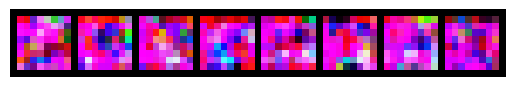

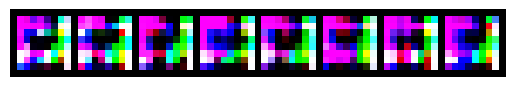

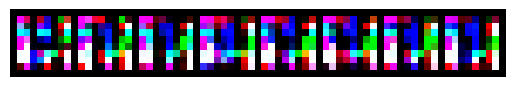

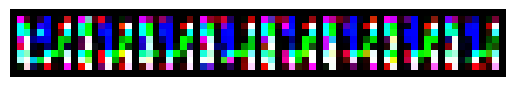

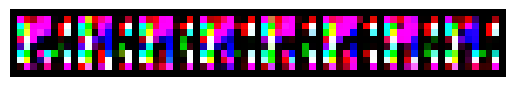

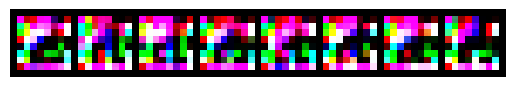

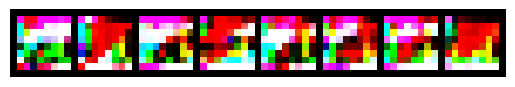

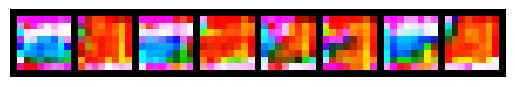

KeyboardInterrupt: 

In [6]:
step = int(log2(config.START_TRAIN_AT_IMG_SIZE / 4)) + 2

# for epochs in tqdm(config.PROGRESSIVE_EPOCHS[step:]):
for epochs in tqdm(range(5)):
    alpha = 1e-5
    loader, dataset = get_loader(4 * 2 ** step)

    alpha = train(disc, gen, loader, dataset, step, alpha, opt_disc, opt_gen)